# Predicting Sports Winners
Data Science and Applied Machine Learning \\
Dr. Kerby \\
Student Name: Ziming Wang

### Question 1: Gather Data
*Gather* data from NBA: https://www.basketball-reference.com/leagues/NBA_2020.html <br>

Data can be downloaded by clicking on the `Share and More` drop-down list at the middle top of available tables. Start off by clicking `Schedule and Results` and downloading the monthly games tables. Combine these into one table (be careful to place the months in the correct chronological order, including October 2020). Then import the full games-results table into python.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
sports = pd.read_csv('GatherData_NBA.csv')
sports

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,"Tue, Oct 22, 2019",8:00p,New Orleans Pelicans,122,Toronto Raptors,130,Box Score,OT,"20,787",NaN
1,"Tue, Oct 22, 2019",10:30p,Los Angeles Lakers,102,Los Angeles Clippers,112,Box Score,NaN,"19,068",NaN
2,"Wed, Oct 23, 2019",7:00p,Chicago Bulls,125,Charlotte Hornets,126,Box Score,NaN,"15,424",NaN
3,"Wed, Oct 23, 2019",7:00p,Detroit Pistons,119,Indiana Pacers,110,Box Score,NaN,"17,923",NaN
4,"Wed, Oct 23, 2019",7:00p,Cleveland Cavaliers,85,Orlando Magic,94,Box Score,NaN,"18,846",NaN
...,...,...,...,...,...,...,...,...,...,...
1138,"Fri, Oct 2, 2020",9:00p,Miami Heat,114,Los Angeles Lakers,124,Box Score,NaN,NaN,NaN
1139,"Sun, Oct 4, 2020",7:30p,Los Angeles Lakers,104,Miami Heat,115,Box Score,NaN,NaN,NaN
1140,"Tue, Oct 6, 2020",9:00p,Los Angeles Lakers,102,Miami Heat,96,Box Score,NaN,NaN,NaN
1141,"Fri, Oct 9, 2020",9:00p,Miami Heat,111,Los Angeles Lakers,108,Box Score,NaN,NaN,NaN


### Question 2: EDA and Preprocessing
Explore your dataset and make any preprocessing adjustments necessary.

In [ ]:
# Change the title to be Home Team and Visitor Team
sports.rename(columns = {'Visitor/Neutral':'Visitor Team', 'Home/Neutral':'Home Team'}, inplace = True)
# Change the name of PTS
sports.rename(columns = {'PTS':'V_PTS','PTS.1':'H_PTS','Unnamed: 7':'Overtime_OT'}, inplace = True)
sports

,Date,Start (ET),Visitor Team,V_PTS,Home Team,H_PTS,Unnamed: 6,Overtime_OT,Attend.,Notes
0,"Tue, Oct 22, 2019",8:00p,New Orleans Pelicans,122,Toronto Raptors,130,Box Score,OT,"20,787",NaN
1,"Tue, Oct 22, 2019",10:30p,Los Angeles Lakers,102,Los Angeles Clippers,112,Box Score,NaN,"19,068",NaN
2,"Wed, Oct 23, 2019",7:00p,Chicago Bulls,125,Charlotte Hornets,126,Box Score,NaN,"15,424",NaN
3,"Wed, Oct 23, 2019",7:00p,Detroit Pistons,119,Indiana Pacers,110,Box Score,NaN,"17,923",NaN
4,"Wed, Oct 23, 2019",7:00p,Cleveland Cavaliers,85,Orlando Magic,94,Box Score,NaN,"18,846",NaN
...,...,...,...,...,...,...,...,...,...,...
1138,"Fri, Oct 2, 2020",9:00p,Miami Heat,114,Los Angeles Lakers,124,Box Score,NaN,NaN,NaN
1139,"Sun, Oct 4, 2020",7:30p,Los Angeles Lakers,104,Miami Heat,115,Box Score,NaN,NaN,NaN
1140,"Tue, Oct 6, 2020",9:00p,Los Angeles Lakers,102,Miami Heat,96,Box Score,NaN,NaN,NaN
1141,"Fri, Oct 9, 2020",9:00p,Miami Heat,111,Los Angeles Lakers,108,Box Score,NaN,NaN,NaN


In [ ]:
# Change Nan to be 0
sports = sports.fillna(0)
sports

,Date,Start (ET),Visitor Team,V_PTS,Home Team,H_PTS,Unnamed: 6,Overtime_OT,Attend.,Notes
0,"Tue, Oct 22, 2019",8:00p,New Orleans Pelicans,122,Toronto Raptors,130,Box Score,OT,"20,787",0
1,"Tue, Oct 22, 2019",10:30p,Los Angeles Lakers,102,Los Angeles Clippers,112,Box Score,0,"19,068",0
2,"Wed, Oct 23, 2019",7:00p,Chicago Bulls,125,Charlotte Hornets,126,Box Score,0,"15,424",0
3,"Wed, Oct 23, 2019",7:00p,Detroit Pistons,119,Indiana Pacers,110,Box Score,0,"17,923",0
4,"Wed, Oct 23, 2019",7:00p,Cleveland Cavaliers,85,Orlando Magic,94,Box Score,0,"18,846",0
...,...,...,...,...,...,...,...,...,...,...
1138,"Fri, Oct 2, 2020",9:00p,Miami Heat,114,Los Angeles Lakers,124,Box Score,0,0,0
1139,"Sun, Oct 4, 2020",7:30p,Los Angeles Lakers,104,Miami Heat,115,Box Score,0,0,0
1140,"Tue, Oct 6, 2020",9:00p,Los Angeles Lakers,102,Miami Heat,96,Box Score,0,0,0
1141,"Fri, Oct 9, 2020",9:00p,Miami Heat,111,Los Angeles Lakers,108,Box Score,0,0,0


In [ ]:
sports.shape

(1143, 10)

In [ ]:
sports.describe()

,V_PTS,H_PTS
count,1143.000000,1143.000000
mean,110.621172,112.671041
std,12.200635,12.616474
min,76.000000,73.000000
25%,102.000000,104.000000
50%,111.000000,112.000000
75%,119.000000,120.000000
max,159.000000,158.000000


### Question 3: Feature Engineering

Create a column for whether or not the home team won the game; call it `HomeWin`. This will become our target -- ie what we are trying to predict.

In [ ]:
sports['HomeWin'] = sports['V_PTS'] < sports['H_PTS']
sports['HomeWin'] = sports["HomeWin"].astype(int)
#print(int(sports['HomeWin'][3]))
sports

,Date,Start (ET),Visitor Team,V_PTS,Home Team,H_PTS,Unnamed: 6,Overtime_OT,Attend.,Notes,HomeWin
0,"Tue, Oct 22, 2019",8:00p,New Orleans Pelicans,122,Toronto Raptors,130,Box Score,OT,"20,787",0,1
1,"Tue, Oct 22, 2019",10:30p,Los Angeles Lakers,102,Los Angeles Clippers,112,Box Score,0,"19,068",0,1
2,"Wed, Oct 23, 2019",7:00p,Chicago Bulls,125,Charlotte Hornets,126,Box Score,0,"15,424",0,1
3,"Wed, Oct 23, 2019",7:00p,Detroit Pistons,119,Indiana Pacers,110,Box Score,0,"17,923",0,0
4,"Wed, Oct 23, 2019",7:00p,Cleveland Cavaliers,85,Orlando Magic,94,Box Score,0,"18,846",0,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,"Fri, Oct 2, 2020",9:00p,Miami Heat,114,Los Angeles Lakers,124,Box Score,0,0,0,1
1139,"Sun, Oct 4, 2020",7:30p,Los Angeles Lakers,104,Miami Heat,115,Box Score,0,0,0,1
1140,"Tue, Oct 6, 2020",9:00p,Los Angeles Lakers,102,Miami Heat,96,Box Score,0,0,0,0
1141,"Fri, Oct 9, 2020",9:00p,Miami Heat,111,Los Angeles Lakers,108,Box Score,0,0,0,0


### Question 4: Feature Engineering II
Create two columns for how many games the home and visitor teams have won thus far in the season. Call them `HomeNumWins` and `VisitorNumWins`.

In [ ]:
from collections import defaultdict
sports['HomeNumWins'] = 0
sports['VisitorNumWins'] = 0

team_wins = {}

for index, row in sports.iterrows():
  if row['Home Team'] not in team_wins:
    team_wins[row['Home Team']] = 0
  if row['Visitor Team'] not in team_wins:
    team_wins[row['Visitor Team']] = 0

  if row['HomeWin'] == 1:
    team_wins[row['Home Team']] += 1
  elif row['HomeWin'] == 0:
    team_wins[row['Visitor Team']] += 1

for index, row in sports.iterrows():

  sports.loc[index,'HomeNumWins'] = team_wins[row['Home Team']]
  sports.loc[index,'VisitorNumWins'] = team_wins[row['Visitor Team']]

# team_wins
sports

,Date,Start (ET),Visitor Team,V_PTS,Home Team,H_PTS,Unnamed: 6,Overtime_OT,Attend.,Notes,HomeWin,HomeNumWins,VisitorNumWins
0,"Tue, Oct 22, 2019",8:00p,New Orleans Pelicans,122,Toronto Raptors,130,Box Score,OT,"20,787",0,1,60,30
1,"Tue, Oct 22, 2019",10:30p,Los Angeles Lakers,102,Los Angeles Clippers,112,Box Score,0,"19,068",0,1,56,68
2,"Wed, Oct 23, 2019",7:00p,Chicago Bulls,125,Charlotte Hornets,126,Box Score,0,"15,424",0,1,23,22
3,"Wed, Oct 23, 2019",7:00p,Detroit Pistons,119,Indiana Pacers,110,Box Score,0,"17,923",0,0,45,20
4,"Wed, Oct 23, 2019",7:00p,Cleveland Cavaliers,85,Orlando Magic,94,Box Score,0,"18,846",0,1,34,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,"Fri, Oct 2, 2020",9:00p,Miami Heat,114,Los Angeles Lakers,124,Box Score,0,0,0,1,68,58
1139,"Sun, Oct 4, 2020",7:30p,Los Angeles Lakers,104,Miami Heat,115,Box Score,0,0,0,1,58,68
1140,"Tue, Oct 6, 2020",9:00p,Los Angeles Lakers,102,Miami Heat,96,Box Score,0,0,0,0,58,68
1141,"Fri, Oct 9, 2020",9:00p,Miami Heat,111,Los Angeles Lakers,108,Box Score,0,0,0,0,68,58


### Question 5: Model

Create a linear regression model and report the training and testing accuracy. Also report the coefficients and comment on the most "important" features in the model.

Remember to split the dataset into training and testing sets and delete any columns that you deem unuseful.

Next create a random forests model and report the training and testing accuracy. Also report the importances and comment on which features they are. Make sure you prune your model until you are not overfit. Plot a representative tree.

In [ ]:
# Delete columns: Unnamed: 6, Unnamed: 7, Notes, Attend., Date, Start (ET)
sports.drop(['Unnamed: 6', 'Notes', 'Date', 'Start (ET)', 'Attend.', 'V_PTS', 'H_PTS'], axis=1, inplace=True)
sports

,Visitor Team,Home Team,Overtime_OT,HomeWin,HomeNumWins,VisitorNumWins
0,New Orleans Pelicans,Toronto Raptors,OT,1,60,30
1,Los Angeles Lakers,Los Angeles Clippers,0,1,56,68
2,Chicago Bulls,Charlotte Hornets,0,1,23,22
3,Detroit Pistons,Indiana Pacers,0,0,45,20
4,Cleveland Cavaliers,Orlando Magic,0,1,34,19
...,...,...,...,...,...,...
1138,Miami Heat,Los Angeles Lakers,0,1,68,58
1139,Los Angeles Lakers,Miami Heat,0,1,58,68
1140,Los Angeles Lakers,Miami Heat,0,0,58,68
1141,Miami Heat,Los Angeles Lakers,0,0,68,58


In [ ]:
current_season = sports[['Visitor Team', 'Home Team', 'Overtime_OT', 'HomeNumWins', 'VisitorNumWins']]
current_season

,Visitor Team,Home Team,Overtime_OT,HomeNumWins,VisitorNumWins
0,New Orleans Pelicans,Toronto Raptors,OT,60,30
1,Los Angeles Lakers,Los Angeles Clippers,0,56,68
2,Chicago Bulls,Charlotte Hornets,0,23,22
3,Detroit Pistons,Indiana Pacers,0,45,20
4,Cleveland Cavaliers,Orlando Magic,0,34,19
...,...,...,...,...,...
1138,Miami Heat,Los Angeles Lakers,0,68,58
1139,Los Angeles Lakers,Miami Heat,0,58,68
1140,Los Angeles Lakers,Miami Heat,0,58,68
1141,Miami Heat,Los Angeles Lakers,0,68,58


In [ ]:
df = pd.get_dummies(current_season)
df

,HomeNumWins,VisitorNumWins,Visitor Team_Atlanta Hawks,Visitor Team_Boston Celtics,Visitor Team_Brooklyn Nets,Visitor Team_Charlotte Hornets,Visitor Team_Chicago Bulls,Visitor Team_Cleveland Cavaliers,Visitor Team_Dallas Mavericks,Visitor Team_Denver Nuggets,Visitor Team_Detroit Pistons,Visitor Team_Golden State Warriors,Visitor Team_Houston Rockets,Visitor Team_Indiana Pacers,Visitor Team_Los Angeles Clippers,Visitor Team_Los Angeles Lakers,Visitor Team_Memphis Grizzlies,Visitor Team_Miami Heat,Visitor Team_Milwaukee Bucks,Visitor Team_Minnesota Timberwolves,Visitor Team_New Orleans Pelicans,Visitor Team_New York Knicks,Visitor Team_Oklahoma City Thunder,Visitor Team_Orlando Magic,Visitor Team_Philadelphia 76ers,Visitor Team_Phoenix Suns,Visitor Team_Portland Trail Blazers,Visitor Team_Sacramento Kings,Visitor Team_San Antonio Spurs,Visitor Team_Toronto Raptors,Visitor Team_Utah Jazz,Visitor Team_Washington Wizards,Home Team_Atlanta Hawks,Home Team_Boston Celtics,Home Team_Brooklyn Nets,Home Team_Charlotte Hornets,Home Team_Chicago Bulls,Home Team_Cleveland Cavaliers,Home Team_Dallas Mavericks,Home Team_Denver Nuggets,Home Team_Detroit Pistons,Home Team_Golden State Warriors,Home Team_Houston Rockets,Home Team_Indiana Pacers,Home Team_Los Angeles Clippers,Home Team_Los Angeles Lakers,Home Team_Memphis Grizzlies,Home Team_Miami Heat,Home Team_Milwaukee Bucks,Home Team_Minnesota Timberwolves,Home Team_New Orleans Pelicans,Home Team_New York Knicks,Home Team_Oklahoma City Thunder,Home Team_Orlando Magic,Home Team_Philadelphia 76ers,Home Team_Phoenix Suns,Home Team_Portland Trail Blazers,Home Team_Sacramento Kings,Home Team_San Antonio Spurs,Home Team_Toronto Raptors,Home Team_Utah Jazz,Home Team_Washington Wizards,Overtime_OT_0,Overtime_OT_2OT,Overtime_OT_OT
0,60,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,56,68,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,23,22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,45,20,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,34,19,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,68,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1139,58,68,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1140,58,68,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1141,68,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# linear regression model
answers = sports['HomeWin']

# For testing and training
Xtrain, Xtest, ytrain, ytest = train_test_split(df, answers)
regmodel = LinearRegression().fit(Xtrain, ytrain)
predictions = regmodel.predict(Xtest)
predictions_train = regmodel.predict(Xtrain)

# Report the training and testing accuracy
rmse_test = math.sqrt(mean_squared_error(ytest, predictions))
R2_test = regmodel.score(Xtest, ytest)
rmse_train = math.sqrt(mean_squared_error(ytrain, predictions_train))
R2_train = regmodel.score(Xtrain, ytrain)
print(rmse_test)
print(R2_test)

print(rmse_train)
print(R2_train)

# Report the coefficients
print(regmodel.coef_)
print(regmodel.intercept_)

equation = 'y = '
equation += '({:.4f}) + '.format(regmodel.intercept_)
for i in np.arange(regmodel.coef_.size):
    equation += '({:.4f})*{} + '.format(regmodel.coef_[i],df.columns[i])
equation

0.46572926437301615
0.11841694676611834
0.43918814009949353
0.22312289879774372
[ 1.52517812e+03 -1.27968725e+07  1.14852387e+09  1.63480502e+09
  1.34047695e+09  1.18691448e+09  1.17411761e+09  1.13572699e+09
  1.46844568e+09  1.59641440e+09  1.14852387e+09  1.08453950e+09
  1.51963317e+09  1.46844568e+09  1.60921127e+09  1.76277374e+09
  1.32768008e+09  1.63480502e+09  1.67319564e+09  1.13572699e+09
  1.27649259e+09  1.16132074e+09  1.49403942e+09  1.32768008e+09
  1.44285193e+09  1.32768008e+09  1.36607070e+09  1.28928946e+09
  1.30208634e+09  1.66039876e+09  1.49403942e+09  1.21250823e+09
  2.69828104e+10  2.69827524e+10  2.69827875e+10  2.69828058e+10
  2.69828073e+10  2.69828119e+10  2.69827722e+10  2.69827570e+10
  2.69828104e+10  2.69828180e+10  2.69827661e+10  2.69827722e+10
  2.69827555e+10  2.69827372e+10  2.69827890e+10  2.69827524e+10
  2.69827478e+10  2.69828119e+10  2.69827951e+10  2.69828088e+10
  2.69827692e+10  2.69827890e+10  2.69827753e+10  2.69827890e+10
  2.698278

'y = (-17320138835.4581) + (1525.1781)*HomeNumWins + (-12796872.4555)*VisitorNumWins + (1148523866.8606)*Visitor Team_Atlanta Hawks + (1634805019.6663)*Visitor Team_Boston Celtics + (1340476953.4088)*Visitor Team_Brooklyn Nets + (1186914483.9727)*Visitor Team_Charlotte Hornets + (1174117611.8043)*Visitor Team_Chicago Bulls + (1135726994.2703)*Visitor Team_Cleveland Cavaliers + (1468445677.6787)*Visitor Team_Dallas Mavericks + (1596414402.4276)*Visitor Team_Denver Nuggets + (1148523866.7321)*Visitor Team_Detroit Pistons + (1084539504.4499)*Visitor Team_Golden State Warriors + (1519633167.7760)*Visitor Team_Houston Rockets + (1468445677.9317)*Visitor Team_Indiana Pacers + (1609211274.7356)*Visitor Team_Los Angeles Clippers + (1762773744.0266)*Visitor Team_Los Angeles Lakers + (1327680080.9944)*Visitor Team_Memphis Grizzlies + (1634805019.7839)*Visitor Team_Miami Heat + (1673195637.0284)*Visitor Team_Milwaukee Bucks + (1135726994.2343)*Visitor Team_Minnesota Timberwolves + (1276492591.168


Comment on the most "important" features in the model:  
Visitor Team_Memphis Grizzlies, Visitor Team_Orlando Magic, Visitor Team_Phoenix Suns, Visitor Team_Oklahoma City Thunder and Visitor Team_Houston Rockets.  
These features are the most important features.



In [ ]:
# A random forests
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 250, min_weight_fraction_leaf=0.001, min_impurity_decrease=0.0001, max_depth=4, random_state = 42)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.001, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf.score(Xtrain, ytrain)

0.7071178529754959

In [ ]:
rf.score(Xtest, ytest)

0.6783216783216783

In [ ]:
# Report the importances and comment on which features they are
rf.feature_importances_

array([0.21672041, 0.22317971, 0.02745639, 0.01036202, 0.00081518,
       0.00207893, 0.01398295, 0.00313687, 0.02301277, 0.00204078,
       0.00477566, 0.00554719, 0.00418683, 0.00146098, 0.01385445,
       0.05567909, 0.00307142, 0.00897386, 0.01602106, 0.00290001,
       0.00407876, 0.00812804, 0.00246827, 0.00735474, 0.00302379,
       0.00578631, 0.00705613, 0.00112782, 0.0013875 , 0.04726965,
       0.00154111, 0.00858683, 0.00227442, 0.00504878, 0.00242705,
       0.01064857, 0.01096871, 0.02233446, 0.00285298, 0.00336063,
       0.004379  , 0.0284579 , 0.00318768, 0.00293501, 0.00406135,
       0.01029704, 0.0017821 , 0.0061205 , 0.01983671, 0.01651638,
       0.01026058, 0.01264626, 0.00203342, 0.00357506, 0.03992499,
       0.00275122, 0.0015725 , 0.00394307, 0.00617583, 0.00440903,
       0.00532587, 0.00280234, 0.00450789, 0.00085012, 0.00466708])

In [ ]:
importances = pd.Series(data=rf.feature_importances_, index=Xtrain.columns)
importances.sort_values(ascending=False)

VisitorNumWins                     0.223180
HomeNumWins                        0.216720
Visitor Team_Los Angeles Lakers    0.055679
Visitor Team_Toronto Raptors       0.047270
Home Team_Philadelphia 76ers       0.039925
                                     ...   
Visitor Team_Indiana Pacers        0.001461
Visitor Team_San Antonio Spurs     0.001387
Visitor Team_Sacramento Kings      0.001128
Overtime_OT_2OT                    0.000850
Visitor Team_Brooklyn Nets         0.000815
Length: 65, dtype: float64

Report the importances and comment on which features they are:  
VisitorNumWins and HomeNumWins are the most important. They have the greatest effect on predicting results.  

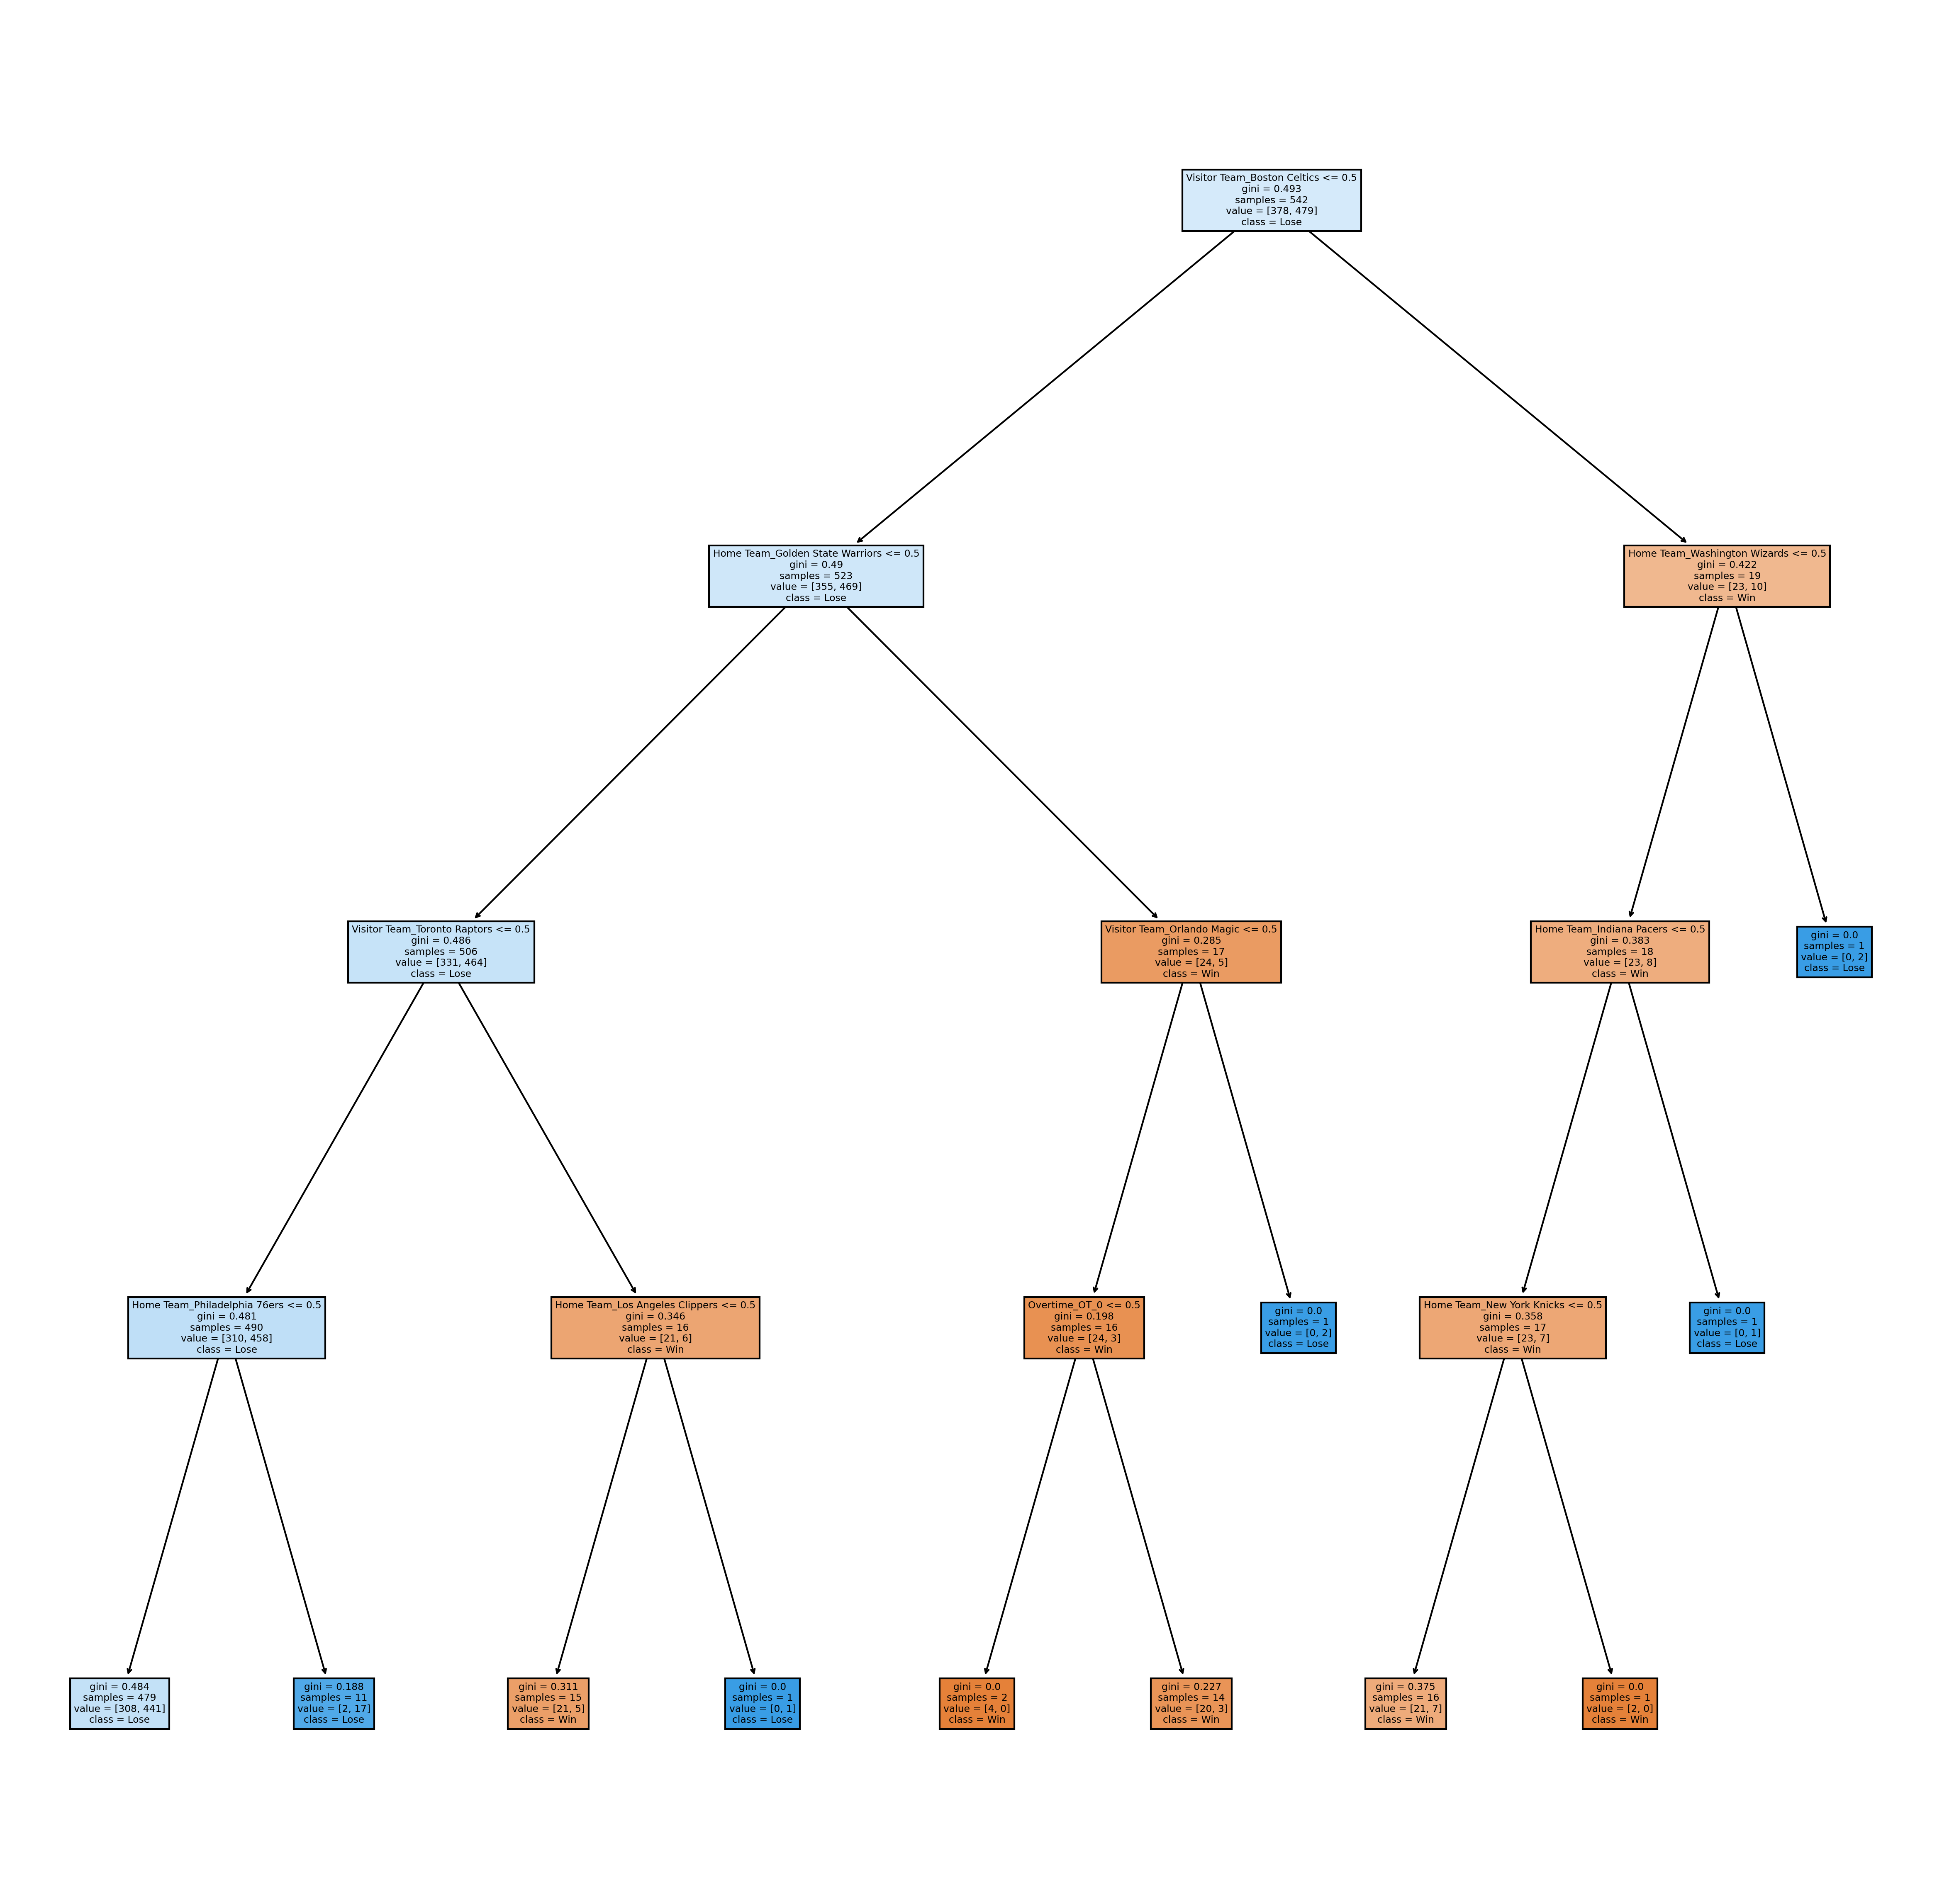

In [ ]:
# Plot a representative tree
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20), dpi=300)
tree.plot_tree(rf.estimators_[0],
               feature_names=df.columns,
               class_names=['Win', 'Lose'],
               filled=True)
plt.show()

### Question 6: Add data from the previous season
Go back to the website and download the team standings from the PREVIOUS season. You will find it in the `Standings` tab. Keep just the number of wins and create two new columns called `HomeWins2019` and `VisitorWins2019`.

In [ ]:
previous_season = pd.read_csv('2019_NBA_Wins.csv')

sports['HomeWins2019'] = 0
sports['VisitorWins2019'] = 0

team_wins = {}

'''for index, row in sports.iterrows():
  if row['Home Team'] not in team_wins:
    team_wins[row['Home Team']] = 0
  if row['Visitor Team'] not in team_wins:
    team_wins[row['Visitor Team']] = 0

  if row['HomeWin'] == 1:
    team_wins[row['Home Team']] += 1
  elif row['HomeWin'] == 0:
    team_wins[row['Visitor Team']] += 1 '''

Home_Wins = {}
Visitor_Wins = {}

for index, row in previous_season.iterrows():

  Home_Wins = dict(zip(previous_season.Team, previous_season.Home + previous_season.Road))
  Visitor_Wins = dict(zip(previous_season.Team, previous_season.Home + previous_season.Road))

for index, row in sports.iterrows():

  sports.loc[index,'HomeWins2019'] = Home_Wins[row['Home Team']]
  sports.loc[index,'VisitorWins2019'] = Visitor_Wins[row['Visitor Team']]

# team_wins
sports

,Visitor Team,Home Team,Overtime_OT,HomeWin,HomeNumWins,VisitorNumWins,HomeWins2019,VisitorWins2019
0,New Orleans Pelicans,Toronto Raptors,OT,1,60,30,58,33
1,Los Angeles Lakers,Los Angeles Clippers,0,1,56,68,48,37
2,Chicago Bulls,Charlotte Hornets,0,1,23,22,39,22
3,Detroit Pistons,Indiana Pacers,0,0,45,20,48,41
4,Cleveland Cavaliers,Orlando Magic,0,1,34,19,42,19
...,...,...,...,...,...,...,...,...
1138,Miami Heat,Los Angeles Lakers,0,1,68,58,37,39
1139,Los Angeles Lakers,Miami Heat,0,1,58,68,39,37
1140,Los Angeles Lakers,Miami Heat,0,0,58,68,39,37
1141,Miami Heat,Los Angeles Lakers,0,0,68,58,37,39


### Question 7: Repeat Model

Repeat your analysis from Question 5.

In [ ]:
previous_season = sports[['Visitor Team', 'Home Team', 'Overtime_OT', 'HomeNumWins', 'VisitorNumWins', 'HomeWins2019', 'VisitorWins2019']]
previous_season

,Visitor Team,Home Team,Overtime_OT,HomeNumWins,VisitorNumWins,HomeWins2019,VisitorWins2019
0,New Orleans Pelicans,Toronto Raptors,OT,60,30,58,33
1,Los Angeles Lakers,Los Angeles Clippers,0,56,68,48,37
2,Chicago Bulls,Charlotte Hornets,0,23,22,39,22
3,Detroit Pistons,Indiana Pacers,0,45,20,48,41
4,Cleveland Cavaliers,Orlando Magic,0,34,19,42,19
...,...,...,...,...,...,...,...
1138,Miami Heat,Los Angeles Lakers,0,68,58,37,39
1139,Los Angeles Lakers,Miami Heat,0,58,68,39,37
1140,Los Angeles Lakers,Miami Heat,0,58,68,39,37
1141,Miami Heat,Los Angeles Lakers,0,68,58,37,39


In [ ]:
df_2 = pd.get_dummies(previous_season)
df_2

,HomeNumWins,VisitorNumWins,HomeWins2019,VisitorWins2019,Visitor Team_Atlanta Hawks,Visitor Team_Boston Celtics,Visitor Team_Brooklyn Nets,Visitor Team_Charlotte Hornets,Visitor Team_Chicago Bulls,Visitor Team_Cleveland Cavaliers,Visitor Team_Dallas Mavericks,Visitor Team_Denver Nuggets,Visitor Team_Detroit Pistons,Visitor Team_Golden State Warriors,Visitor Team_Houston Rockets,Visitor Team_Indiana Pacers,Visitor Team_Los Angeles Clippers,Visitor Team_Los Angeles Lakers,Visitor Team_Memphis Grizzlies,Visitor Team_Miami Heat,Visitor Team_Milwaukee Bucks,Visitor Team_Minnesota Timberwolves,Visitor Team_New Orleans Pelicans,Visitor Team_New York Knicks,Visitor Team_Oklahoma City Thunder,Visitor Team_Orlando Magic,Visitor Team_Philadelphia 76ers,Visitor Team_Phoenix Suns,Visitor Team_Portland Trail Blazers,Visitor Team_Sacramento Kings,Visitor Team_San Antonio Spurs,Visitor Team_Toronto Raptors,Visitor Team_Utah Jazz,Visitor Team_Washington Wizards,Home Team_Atlanta Hawks,Home Team_Boston Celtics,Home Team_Brooklyn Nets,Home Team_Charlotte Hornets,Home Team_Chicago Bulls,Home Team_Cleveland Cavaliers,Home Team_Dallas Mavericks,Home Team_Denver Nuggets,Home Team_Detroit Pistons,Home Team_Golden State Warriors,Home Team_Houston Rockets,Home Team_Indiana Pacers,Home Team_Los Angeles Clippers,Home Team_Los Angeles Lakers,Home Team_Memphis Grizzlies,Home Team_Miami Heat,Home Team_Milwaukee Bucks,Home Team_Minnesota Timberwolves,Home Team_New Orleans Pelicans,Home Team_New York Knicks,Home Team_Oklahoma City Thunder,Home Team_Orlando Magic,Home Team_Philadelphia 76ers,Home Team_Phoenix Suns,Home Team_Portland Trail Blazers,Home Team_Sacramento Kings,Home Team_San Antonio Spurs,Home Team_Toronto Raptors,Home Team_Utah Jazz,Home Team_Washington Wizards,Overtime_OT_0,Overtime_OT_2OT,Overtime_OT_OT
0,60,30,58,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,56,68,48,37,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,23,22,39,22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,45,20,48,41,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,34,19,42,19,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,68,58,37,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1139,58,68,39,37,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1140,58,68,39,37,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1141,68,58,37,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# linear regression model
answers = sports['HomeWin']

# For testing and training
Xtrain, Xtest, ytrain, ytest = train_test_split(df_2, answers)
regmodel = LinearRegression().fit(Xtrain, ytrain)
predictions = regmodel.predict(Xtest)
predictions_train = regmodel.predict(Xtrain)

#Report the tyraining and testing accuracy
rmse_test = math.sqrt(mean_squared_error(ytest, predictions))
R2_test = regmodel.score(Xtest, ytest)
rmse_train = math.sqrt(mean_squared_error(ytrain, predictions_train))
R2_train = regmodel.score(Xtrain, ytrain)
print(rmse_test)
print(R2_test)

print(rmse_train)
print(R2_train)

#Report the coefficients
print(regmodel.coef_)
print(regmodel.intercept_)

equation = 'y = '
equation += '({:.4f}) + '.format(regmodel.intercept_)
for i in np.arange(regmodel.coef_.size):
    equation += '({:.4f})*{} + '.format(regmodel.coef_[i],df_2.columns[i])
equation

0.46363150399997555
0.13301817494484003
0.4388194917989337
0.22280697234624627
[ 0.00972536 -0.01058066  0.00186572  0.00172504  0.02582067  0.02232778
  0.02337007 -0.11947468  0.03394864 -0.0373018  -0.08756891  0.06180444
  0.03841063  0.06117442  0.09439209 -0.01812864 -0.03156247  0.01927838
  0.02127073  0.09659584 -0.03155946 -0.11064474 -0.05670776  0.05561353
 -0.04418044 -0.02639159  0.19436729  0.00846836  0.00470784 -0.04483867
  0.00443766 -0.16171711 -0.05408323  0.05817113  0.06113462 -0.08812929
  0.01631171 -0.12250112  0.13644346 -0.10061343 -0.04549317  0.01741519
 -0.08766831 -0.0390237   0.04436299  0.06264936  0.03251158 -0.10189654
  0.02534236  0.09596766 -0.02862425 -0.13547607  0.04736647 -0.00660536
 -0.00892223  0.02973843  0.24951135 -0.02591345  0.07341206 -0.00206778
 -0.0301936  -0.15032877  0.00319774  0.07809209 -0.14284137  0.2076545
 -0.06481314]
0.5649432350800964


'y = (0.5649) + (0.0097)*HomeNumWins + (-0.0106)*VisitorNumWins + (0.0019)*HomeWins2019 + (0.0017)*VisitorWins2019 + (0.0258)*Visitor Team_Atlanta Hawks + (0.0223)*Visitor Team_Boston Celtics + (0.0234)*Visitor Team_Brooklyn Nets + (-0.1195)*Visitor Team_Charlotte Hornets + (0.0339)*Visitor Team_Chicago Bulls + (-0.0373)*Visitor Team_Cleveland Cavaliers + (-0.0876)*Visitor Team_Dallas Mavericks + (0.0618)*Visitor Team_Denver Nuggets + (0.0384)*Visitor Team_Detroit Pistons + (0.0612)*Visitor Team_Golden State Warriors + (0.0944)*Visitor Team_Houston Rockets + (-0.0181)*Visitor Team_Indiana Pacers + (-0.0316)*Visitor Team_Los Angeles Clippers + (0.0193)*Visitor Team_Los Angeles Lakers + (0.0213)*Visitor Team_Memphis Grizzlies + (0.0966)*Visitor Team_Miami Heat + (-0.0316)*Visitor Team_Milwaukee Bucks + (-0.1106)*Visitor Team_Minnesota Timberwolves + (-0.0567)*Visitor Team_New Orleans Pelicans + (0.0556)*Visitor Team_New York Knicks + (-0.0442)*Visitor Team_Oklahoma City Thunder + (-0.026

Comment on the most "important" features in the model:  
Visitor Team_Philadelphia 76ers, Visitor Team_Atlanta Hawks, Home Team_Philadelphia 76ers, Home Team_Miami Heat and Visitor Team_Brooklyn Nets.  
These features are the most important features.

In [ ]:
# A random forests
from sklearn.ensemble import RandomForestClassifier
rf_2 = RandomForestClassifier(n_estimators = 250, min_weight_fraction_leaf=0.001, min_impurity_decrease=0.0001, max_depth=4, random_state = 42)
rf_2.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.001, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_2.score(Xtrain, ytrain)

0.7036172695449242

In [ ]:
rf_2.score(Xtest, ytest)

0.6608391608391608

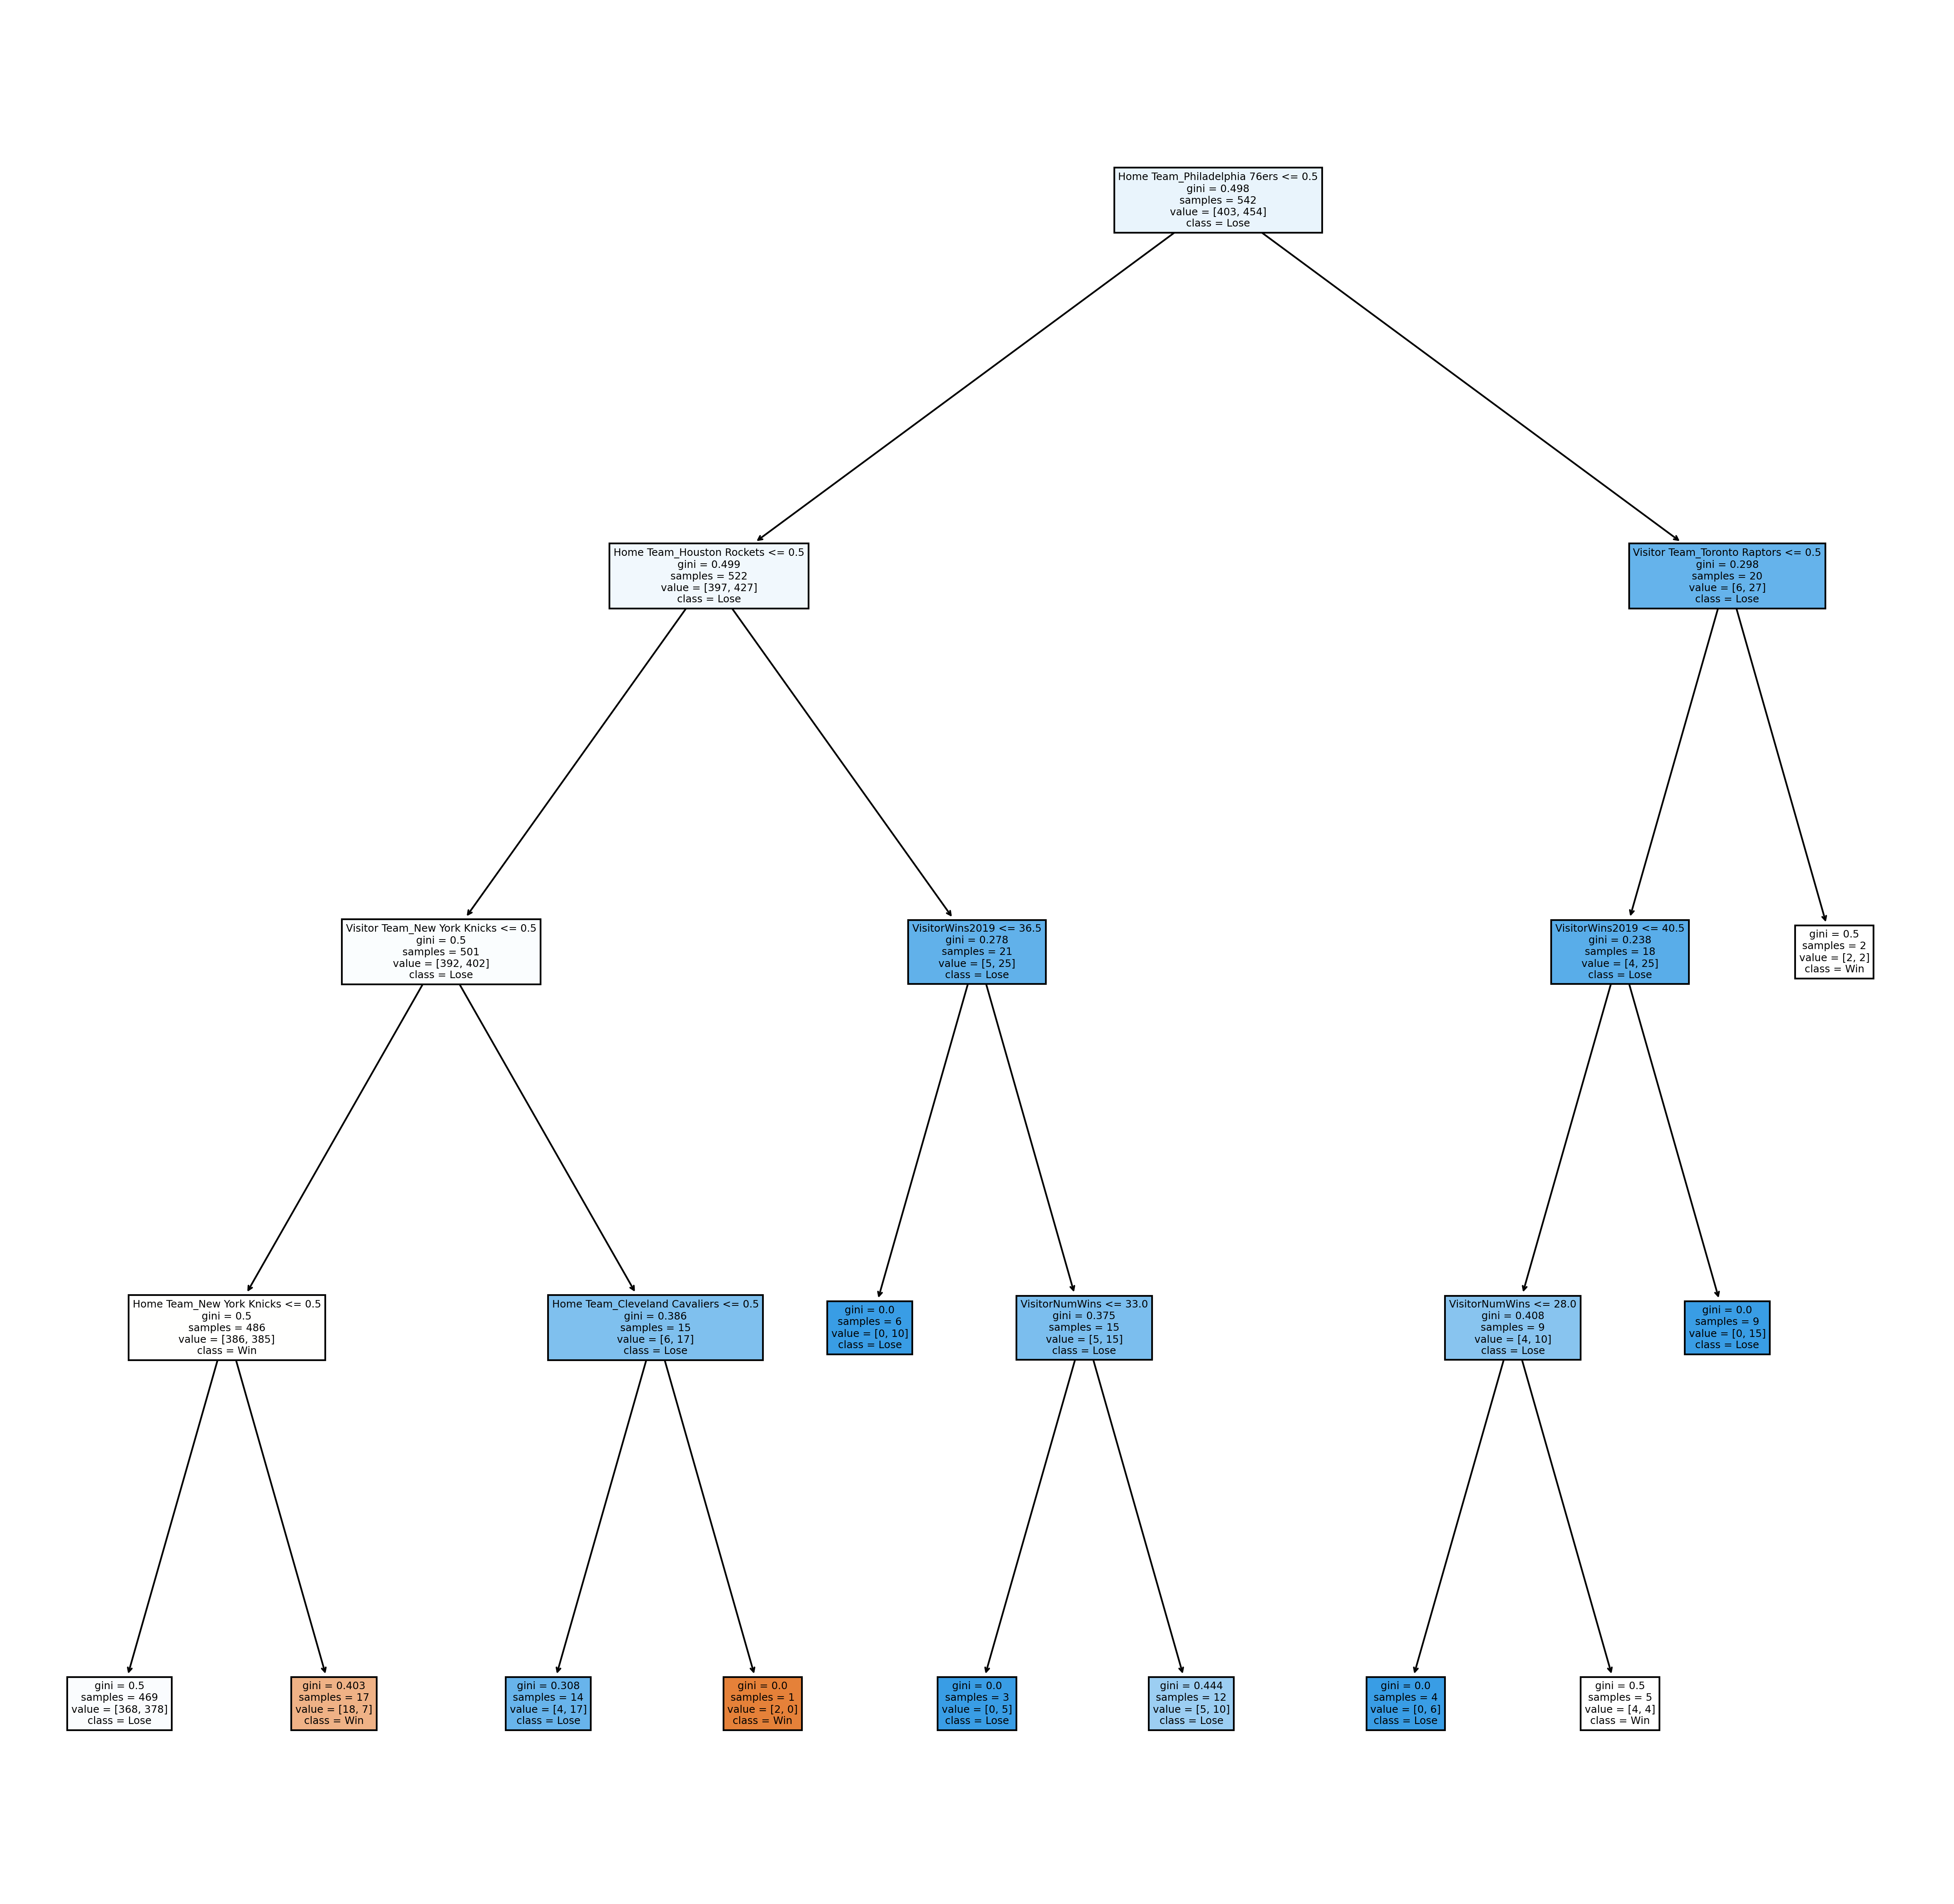

In [ ]:
# Plot a representative tree
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20), dpi=300)
tree.plot_tree(rf_2.estimators_[0],
               feature_names=df_2.columns,
               class_names=['Win', 'Lose'],
               filled=True)
plt.show()

In [ ]:
# Report the importances and comment on which features they are
rf_2.feature_importances_
importances_previous = pd.Series(data=rf_2.feature_importances_, index=Xtrain.columns)
importances_previous.sort_values(ascending=False)

HomeNumWins                         0.228867
VisitorNumWins                      0.188791
HomeWins2019                        0.095622
VisitorWins2019                     0.085660
Home Team_Minnesota Timberwolves    0.033406
                                      ...   
Visitor Team_San Antonio Spurs      0.001306
Home Team_Chicago Bulls             0.001244
Home Team_Oklahoma City Thunder     0.001212
Visitor Team_Orlando Magic          0.001143
Overtime_OT_2OT                     0.000857
Length: 67, dtype: float64

Report the importances and comment on which features they are:  
HomeNumWins and VisitorNumWins are the most important.  
HomeWins2019 and VisitorWins2019 are also important.  
They have the greatest effect on predicting results.  

### Question 8: Analysis and Discussion
What was your best-performing model? \\
How well did it do? \\
Was it overfit? \\
What seems to be the most important feature(s)? \\
How well did your model perform compared to blindly guessing the Home Team won?

1. I think my best-performing model is random forests model.
2. Because the final result is more accurate and closer to the true value than the linear regression model. For example, this model shows about 0.70 accuracy on the training data and 0.70 accuracy on the testing data. They are better than the linear regression model.  
3. No, it was not overfit.
4. I think the most important features are HomeNumWins and VisitorNumWins.
5. I think my model is more accurate than my own guessing. Because I make predictions by myself will make mistakes and sometimes bring my own opinions. My model gives a more neutral prediction result that is close to the true value.

### Question 9: Sample testing

Take the best five teams from the 2018-2019 season and the five worst teams from 2018-2019, and compare their number of 2019-2020 season wins. Are they significantly different (if so, at what confidence level?)

In [ ]:
season_2019 = pd.read_csv('2019_NBA_Wins.csv')
five_best = season_2019[season_2019['Rk'] <= 5]
five_worst = season_2019[season_2019['Rk'] >= 26]

ten_teams = five_best.append(five_worst)
ten_teams

,Rk,Team,Home,Road
0,1,Milwaukee Bucks,33,27
1,2,Toronto Raptors,32,26
2,3,Golden State Warriors,30,27
3,4,Denver Nuggets,34,20
4,5,Houston Rockets,31,22
25,26,Atlanta Hawks,17,12
26,27,Chicago Bulls,9,13
27,28,Cleveland Cavaliers,13,6
28,29,Phoenix Suns,12,7
29,30,New York Knicks,9,8


In [ ]:
# The number of wins from 2019 season
ten_teams['NumWins_2019'] = 0
ten_teams['NumWins_2020'] = 0
ten_teams['NumWins_2019'] = ten_teams['Home'] + ten_teams['Road']
ten_teams.drop(['Home', 'Road'], axis=1, inplace=True)

# The number of wins from 2020 season
team_wins = {}
for index, row in sports.iterrows():
  if row['Home Team'] not in team_wins:
    team_wins[row['Home Team']] = 0
  if row['Visitor Team'] not in team_wins:
    team_wins[row['Visitor Team']] = 0

  if row['HomeWin'] == 1:
    team_wins[row['Home Team']] += 1
  elif row['HomeWin'] == 0:
    team_wins[row['Visitor Team']] += 1

for index, row in ten_teams.iterrows():
  ten_teams.loc[index,'NumWins_2020'] = team_wins[row['Team']]

ten_teams

,Rk,Team,NumWins_2019,NumWins_2020
0,1,Milwaukee Bucks,60,61
1,2,Toronto Raptors,58,60
2,3,Golden State Warriors,57,15
3,4,Denver Nuggets,54,55
4,5,Houston Rockets,53,49
25,26,Atlanta Hawks,29,20
26,27,Chicago Bulls,22,22
27,28,Cleveland Cavaliers,19,19
28,29,Phoenix Suns,19,34
29,30,New York Knicks,17,21


In [ ]:
# Add a column which called Difference
ten_teams['Difference'] = ten_teams['NumWins_2019'] - ten_teams['NumWins_2020']
ten_teams

,Rk,Team,NumWins_2019,NumWins_2020,Difference
0,1,Milwaukee Bucks,60,61,-1
1,2,Toronto Raptors,58,60,-2
2,3,Golden State Warriors,57,15,42
3,4,Denver Nuggets,54,55,-1
4,5,Houston Rockets,53,49,4
25,26,Atlanta Hawks,29,20,9
26,27,Chicago Bulls,22,22,0
27,28,Cleveland Cavaliers,19,19,0
28,29,Phoenix Suns,19,34,-15
29,30,New York Knicks,17,21,-4


In [ ]:
# Ten teams in the 2019 season
n=10
t_critical = 1.96
sample = ten_teams
x_bar = ten_teams['NumWins_2019'].mean()
s = ten_teams['NumWins_2019'].std()

low = x_bar - t_critical*(s/n**0.5)
high = x_bar + t_critical*(s/n**0.5)
print('[',low,'--',high,']')

[ 27.077080682128134 -- 50.52291931787186 ]


In [ ]:
# Ten teams in the 2020 season
n=10
t_critical = 1.96
sample = ten_teams
x_bar = ten_teams['NumWins_2020'].mean()
s = ten_teams['NumWins_2020'].std()

low = x_bar - t_critical*(s/n**0.5)
high = x_bar + t_critical*(s/n**0.5)
print('[',low,'--',high,']')

[ 24.02216646633174 -- 47.17783353366826 ]


In [ ]:
# Get the confidence interval from Difference
n=10
t_critical = 1.96
sample = ten_teams
x_bar = ten_teams['Difference'].mean()
s = ten_teams['Difference'].std()

low = x_bar - t_critical*(s/n**0.5)
high = x_bar + t_critical*(s/n**0.5)
print('[',low,'--',high,']')

[ -6.0524549054711825 -- 12.452454905471182 ]


Yes, I think they are significantly different.  
And the confidence level is 27.077080682128134 -- 50.52291931787186 for 2019 season.  
The confidence level is 24.02216646633174 -- 47.17783353366826 for 2020 season.  
The confidence level is -6.0524549054711825 -- 12.452454905471182 for the difference of ten teams.  
The first two confidence intervals represent the difference between the performance of the 10 teams in the 2019 and 2020 seasons. Obviously, the 2020 season has decreased a bit. The third confidence interval represents a range of variation in the overall magnitude.

### GRADUATE STUDENTS ONLY
Incorporate new data in at least two different ways: \\
1) Go back to the website and incorporate more data; \\
2) Feature engineer another feature from the data you have.

Repeat Question 5 modeling.

Repeat Question 8 analysis.